In [6]:
library('ggplot2')
library('reshape2')
library('ggpubr')
library(glmnet)
library(doMC)
library(survival)
library(data.table)
library(mltools)
library(CoxBoost)
library(randomForestSRC)
library(CoxHD)
library(Hmisc)
library(gridExtra)
library("survminer")
library(dplyr)
library(broom)
library(tidyr)
library(tidyverse)
source("../../../src/tools.R")
source('run_prognosis.R')
options(repr.plot.res        = 100, # set a medium-definition resolution for the jupyter notebooks plots (DPI)
        repr.matrix.max.rows = 250, # set the maximum number of rows displayed
        repr.matrix.max.cols = 250) # set the maximum number of columns displayed

Loading required package: magrittr
Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-16

Loading required package: iterators
Loading required package: parallel

Attaching package: ‘data.table’

The following objects are masked from ‘package:reshape2’:

    dcast, melt

Loading required package: prodlim

 randomForestSRC 2.9.0 
 
 Type rfsrc.news() to see new features, changes, and bug fixes. 
 

Loading required package: RColorBrewer
Loading required package: lattice
Loading required package: Formula

Attaching package: ‘Hmisc’

The following object is masked from ‘package:randomForestSRC’:

    impute

The following objects are masked from ‘package:base’:

    format.pval, units


Attaching package: ‘dplyr’

The following object is masked from ‘package:gridExtra’:

    combine

The following objects are masked from ‘package:Hmisc’:

    src, summarize

The following objects are masked from ‘package:data.table’:

    between, first, last

The followin

In [7]:
df_final <- read.table("prognosis_comp_final.tsv",sep='\t',header=T)
### Features that we can use
###-----------------------------------------------------------------------------
all_features <-c(1:180) #not used
clin_demo_comp <-c(155:180) #not used
clin_demo_cyto_gen_comp <- c(2:180) #not used
comp <- c(164:180) #not used
cyto_comp <-c(86:154,164:180) #not used
cyto_gen_comp <- c(2:154,164:180) #not used
eln_clin_demo_comp <- c(1,155:180) #not used
eln_cyto_comp <- c(1,86:154,164:180) #not used
eln_cyto_gen_comp <- c(1:154,164:180) #not used
eln_gen_comp <- c(1:85,164:180) #not used
gen_comp <- c(2:85,164:180) #not used
clin_comp <- c(155:161,164:180) #not used
clin_cyto_comp <- c(86:161,164:180) #not used
clin_gen_comp <- c(2:85,155:161,164:180) #not used
eln_clin_comp <- c(1,155:161,164:180) #not used
age <- c(163)
gen_age <- c(2:85,163)
eln_clin_gen <-  c(1:85,155:161)
eln_demo_gen <- c(1:85,162:163)
eln_clin_demo_cyto_gen <- c(1:163)
eln_clin_demo_cyto <- c(1,86:163)
eln_clin_demo_gen <- c(1:85,155:163)  ##START HERE
eln_clin_demo <- c(1,155:163)
eln_clin <- c(1,155:161)
eln_cyto_gen <- c(1:154)
clin_demo_cyto_gen <- c(2:163)
clin_demo_cyto <- c(86:163)
clin_demo_gen <- c(2:85,155:163)
clin_demo <- c(155:163)
cyto_gen <- c(2:154)
cyto <- c(86:154)
gen <- c(2:85)
clin_gen <- c(2:85,155:161)
clin_cyto <- c(86:161)
demo_gen <- c(2:85,162:163)
demo_cyto <- c(86:154,162:163)  

###Without age:
all_features_without_age <-c(1:162,164:180) #not used
clin_demo_comp_without_age <-c(155:162,164:180) #not used
clin_demo_cyto_gen_comp_without_age <- c(2:162,164:180) #not used
eln_clin_demo_comp_without_age <- c(1,155:162,164:180) #not used
eln_demo_gen_without_age <- c(1:85,162)
eln_clin_demo_cyto_gen_without_age <- c(1:162)
eln_clin_demo_cyto_without_age <- c(1,86:162)
eln_clin_demo_gen_without_age <- c(1:85,155:162)
eln_clin_demo_without_age <- c(1,155:162)
clin_demo_cyto_gen_without_age <- c(2:162)
clin_demo_cyto_without_age <- c(86:162)
clin_demo_gen_without_age <- c(2:85,155:162)
clin_demo_without_age <- c(155:162)
demo_gen_without_age <- c(2:85,162)
demo_cyto_without_age <- c(86:154,162)   

###
###-----------------------------------------------------------------------------

x <- data.matrix(df_final)
y <- data.matrix(df_final[,c("os","os_status")])

colnames(y) = c("time","status")
response=y
design=x[,all_features]
nrepeats=2
nfolds=5
set.seed(17)
# Make folds

n = nrow(design)
folds <- list()
for (i in seq(100)) {
    folds <- c(folds,split(sample(seq(n)), rep(1:nfolds, length = n)))
}
nexp = length(folds) # the total number CV of experiments


# FEATURE IMPORTANCE FOR GLMNET:

# I) Using BOOTSTRAPPING

In [46]:
bootstrapping <- function(features=all_features,x,y,n_exp=100,alpha=0.7,mc.cores=50,algo="glm"){
    set.seed(17)
    res_bootstrap <- data.frame('feature' = character(),
                      'coef' = numeric())
    design=x[,features]
    n = nrow(design)
    folds <- list()

    for (i in seq(n_exp)) {
        folds[[i]] <- sample(1:n, 0.8 * n, replace = TRUE)
    }

    nexp = length(folds)
    print("Start Bootstrapping")
    rescv = mclapply(seq(nexp),
                   FUN=function(iexp) {
                       set.seed(17)
                       cat(".")
                       x_sampling = design[folds[[iexp]],]
                       y_sampling = y[folds[[iexp]],]
                       if (algo=="glm"){
                           cvfit <- cv.glmnet(x_sampling, y_sampling, family = 'cox', alpha=alpha, nfolds = 20, grouped = TRUE)
                           tmp <- as.data.frame(as.matrix(coef(cvfit, s = "lambda.min")))
                       } else if (algo=="boost"){
                           cvfit<-CoxBoost(time=y_sampling[,1],status=y_sampling[,2],x=x_sampling)
                           tmp <- as.data.frame(as.matrix(coefficients(cvfit)))
                       } else if (algo=="rfx"){
                           cvfit<-CoxRFX(data.frame(x_sampling),Surv(time=y_sampling[,1],event=y_sampling[,2]) , max.iter =50,tol=1e-3)
                           tmp <- as.data.frame(as.matrix(coef(cvfit)))
                       } else if (algo=="rfs"){
                           cvfit <- rfsrc(Surv(time, status) ~ ., data=data.frame(x_sampling,y_sampling), ntree=1050, importance="TRUE",nodesize=20)
                           tmp <- as.data.frame(as.matrix(cvfit$importance))
                       }
                       colnames(tmp) <- 'coef'
                       tmp <- rownames_to_column(tmp, var = 'feature')


                   },
                   mc.cores=mc.cores
                   )

    for(i in 1:length(rescv)){
        res_bootstrap <- rbind(res_bootstrap,rescv[[i]])
    }


    res_bootstrap <- res_bootstrap[res_bootstrap$coef != 0,]
    return (res_bootstrap)
    }

In [75]:
x <- data.matrix(df_final)
y <- data.matrix(df_final[,c("os","os_status")])

colnames(y) = c("time","status")
response=y
prognosis_features<- list(clin_demo=clin_demo,eln_clin=eln_clin)
algos <-c("glm","rfs","boost","rfx")
alphas=c(0,0.7,1)
for (i in 1:length(prognosis_features)){
    for (algo in algos){
        if (algo=="glm"){
            for (alpha in alphas){
                print(alpha)
                print(algo)
                bootstrap <- bootstrapping(prognosis_features[[i]],x,y,100,alpha,8,algo)
                tmp_1 <- bootstrap  %>% group_by(feature) %>% summarise_all(sum)
                tmp_2 <- bootstrap  %>% group_by(feature) %>% count(feature)
                print(paste(paste(names(prognosis_features)[i],paste(algo,alpha,sep="_"),sep="_bootstrap_"),".tsv",sep=""))
                write.table(data.frame(merge(tmp_1,tmp_2,by='feature')),paste(paste(names(prognosis_features)[i],paste(algo,alpha,sep="_"),sep="_bootstrap_"),".tsv",sep=""),quote=F,sep='\t')

                if (alpha==0.7){
                    tmp_1_pos <- tmp_1[tmp_1$coef>0,]
                    tmp_1_neg <-  tmp_1[tmp_1$coef<0,]
                    features_reduced <- union(union(tmp_1_pos[tmp_1_pos$coef > quantile(tmp_1_pos$coef,0.90),]$feature,tmp_1_neg[tmp_1_neg$coef < quantile(tmp_1_neg$coef,0.15),]$feature),tmp_2[tmp_2$n > quantile(tmp_2$n,0.85),]$feature)
                    if (length(features_reduced)<2){features_reduced <- union(union(tmp_1_pos[tmp_1_pos$coef > quantile(tmp_1_pos$coef,0.90),]$feature,tmp_1_neg[tmp_1_neg$coef < quantile(tmp_1_neg$coef,0.15),]$feature),tmp_2[tmp_2$n > 0,]$feature)}
                    print(features_reduced)

                    predictors <- c(rep(list(predictorGLM),11),rep(list(predictorRF),1),predictorBoost,predictorRFX)
                    str_predictors <-c(rep("CoxGLM",11),"RFS","CoxBoost","RFX")
                    l_alpha <-seq(0,1,0.1)
                    l_ntree <- c(1050)
                    mc.cores <- 50
                    nodesize <- c(20)
                    print("DONE")
                    write.table(launch_prognosis(data.matrix(df_final[,features_reduced]),y=y,predictors=predictors,str_predictors=str_predictors,l_alpha=l_alpha,nrepeats=2,l_ntree=l_ntree,nodesize=nodesize,
                                mc.cores=mc.cores),paste(names(prognosis_features)[i],"_reduced.tsv",sep=""),quote=F,sep='\t')
                    print("DONE")
                }
            }
        } else {
                print(algo)
                bootstrap <- bootstrapping(prognosis_features[[i]],x,y,100,0.7,8,algo)
                tmp_1 <- bootstrap  %>% group_by(feature) %>% summarise_all(sum)
                tmp_2 <- bootstrap  %>% group_by(feature) %>% count(feature)

                write.table(data.frame(merge(tmp_1,tmp_2,by='feature')),paste(paste(names(prognosis_features)[i],algo,sep="_bootstrap_"),".tsv",sep=""),quote=F,sep='\t')
    print ('next')
        }
    }
}

[1] 0
[1] "glm"
[1] "Start Bootstrapping"
[1] "clin_demo_bootstrap_glm_0.tsv"
[1] 0.7
[1] "glm"
[1] "Start Bootstrapping"
[1] "clin_demo_bootstrap_glm_0.7.tsv"
[1] "perf_status" "ahd"        
[1] "DONE"
[1] "start CV"
[1] "start CV"
[1] "start CV"
[1] "start CV"
[1] "start CV"
[1] "start CV"
[1] "start CV"
[1] "start CV"
[1] "start CV"
[1] "start CV"
[1] "start CV"
[1] "start CV"
[1] "start CV"
[1] "start CV"
       CoxGLM_0 CoxGLM_0.1 CoxGLM_0.2 CoxGLM_0.3 CoxGLM_0.4 CoxGLM_0.5
 [1,] 0.6085738  0.6085738  0.6085738  0.6085738  0.6085738  0.6085738
 [2,] 0.5665381  0.5665381  0.5665381  0.5665381  0.5665381  0.5665381
 [3,] 0.5950724  0.5950724  0.5950724  0.5950724  0.5950724  0.5950724
 [4,] 0.5914989  0.5914989  0.5914989  0.5914989  0.5914989  0.5914989
 [5,] 0.6084453  0.6084453  0.6084453  0.6084453  0.6084453  0.6084453
 [6,] 0.5929413  0.5929413  0.5929413  0.5929413  0.5929413  0.5929413
 [7,] 0.5842590  0.5842590  0.5842590  0.5842590  0.5842590  0.5842590
 [8,] 0.6017463  0.

In [73]:
read.table("clin_demo_reduced.tsv",sep='\t')

ERROR: Error in scan(file = file, what = what, sep = sep, quote = quote, dec = dec, : line 2 did not have 20 elements


In [55]:
bootstrap <- bootstrapping(prognosis_features[[i]],x,y,5,alpha,1,model)
bootstrap

[1] "Start Bootstrapping"


Warning message in mclapply(seq(nexp), FUN = function(iexp) {:
“all scheduled cores encountered errors in user code”

factor(0)
Levels: Error in FUN(X[[i]], ...) : object 'model' not found\n

In [61]:
k <- bootstrapping(eln_clin,x,y,2,0.7,50,"rfs")

[1] "Start Bootstrapping"


In [44]:

tmp_1 <- k  %>% group_by(feature) %>% summarise_all(sum)
tmp_2 <- k  %>% group_by(feature) %>% count(feature)

tmp_1_pos <- tmp_1[tmp_1$coef>0,]
tmp_1_neg <-  tmp_1[tmp_1$coef<0,]
features_reduced <- union(union(tmp_1_pos[tmp_1_pos$coef > quantile(tmp_1_pos$coef,0.90),]$feature,tmp_1_neg[tmp_1_neg$coef < quantile(tmp_1_neg$coef,0.15),]$feature),tmp_2[tmp_2$n > quantile(tmp_2$n,0.85),]$feature)
if (length(features_reduced)<2){features_reduced <- union(union(tmp_1_pos[tmp_1_pos$coef > quantile(tmp_1_pos$coef,0.90),]$feature,tmp_1_neg[tmp_1_neg$coef < quantile(tmp_1_neg$coef,0.15),]$feature),tmp_2[tmp_2$n > 0,]$feature)}


[1] "eln_2017_ratio" "ahd"            "bm_blasts"      "hb"            
[5] "perf_status"    "plt"            "secondary"      "wbc"

In [5]:
bootstrap_all_glm <- bootstrapping(all_features,x,y,100,0.7,50,"glm")


[1] "Start Bootstrapping"


ERROR: Error in mclapply(seq(nexp), FUN = function(iexp) {: could not find function "mclapply"


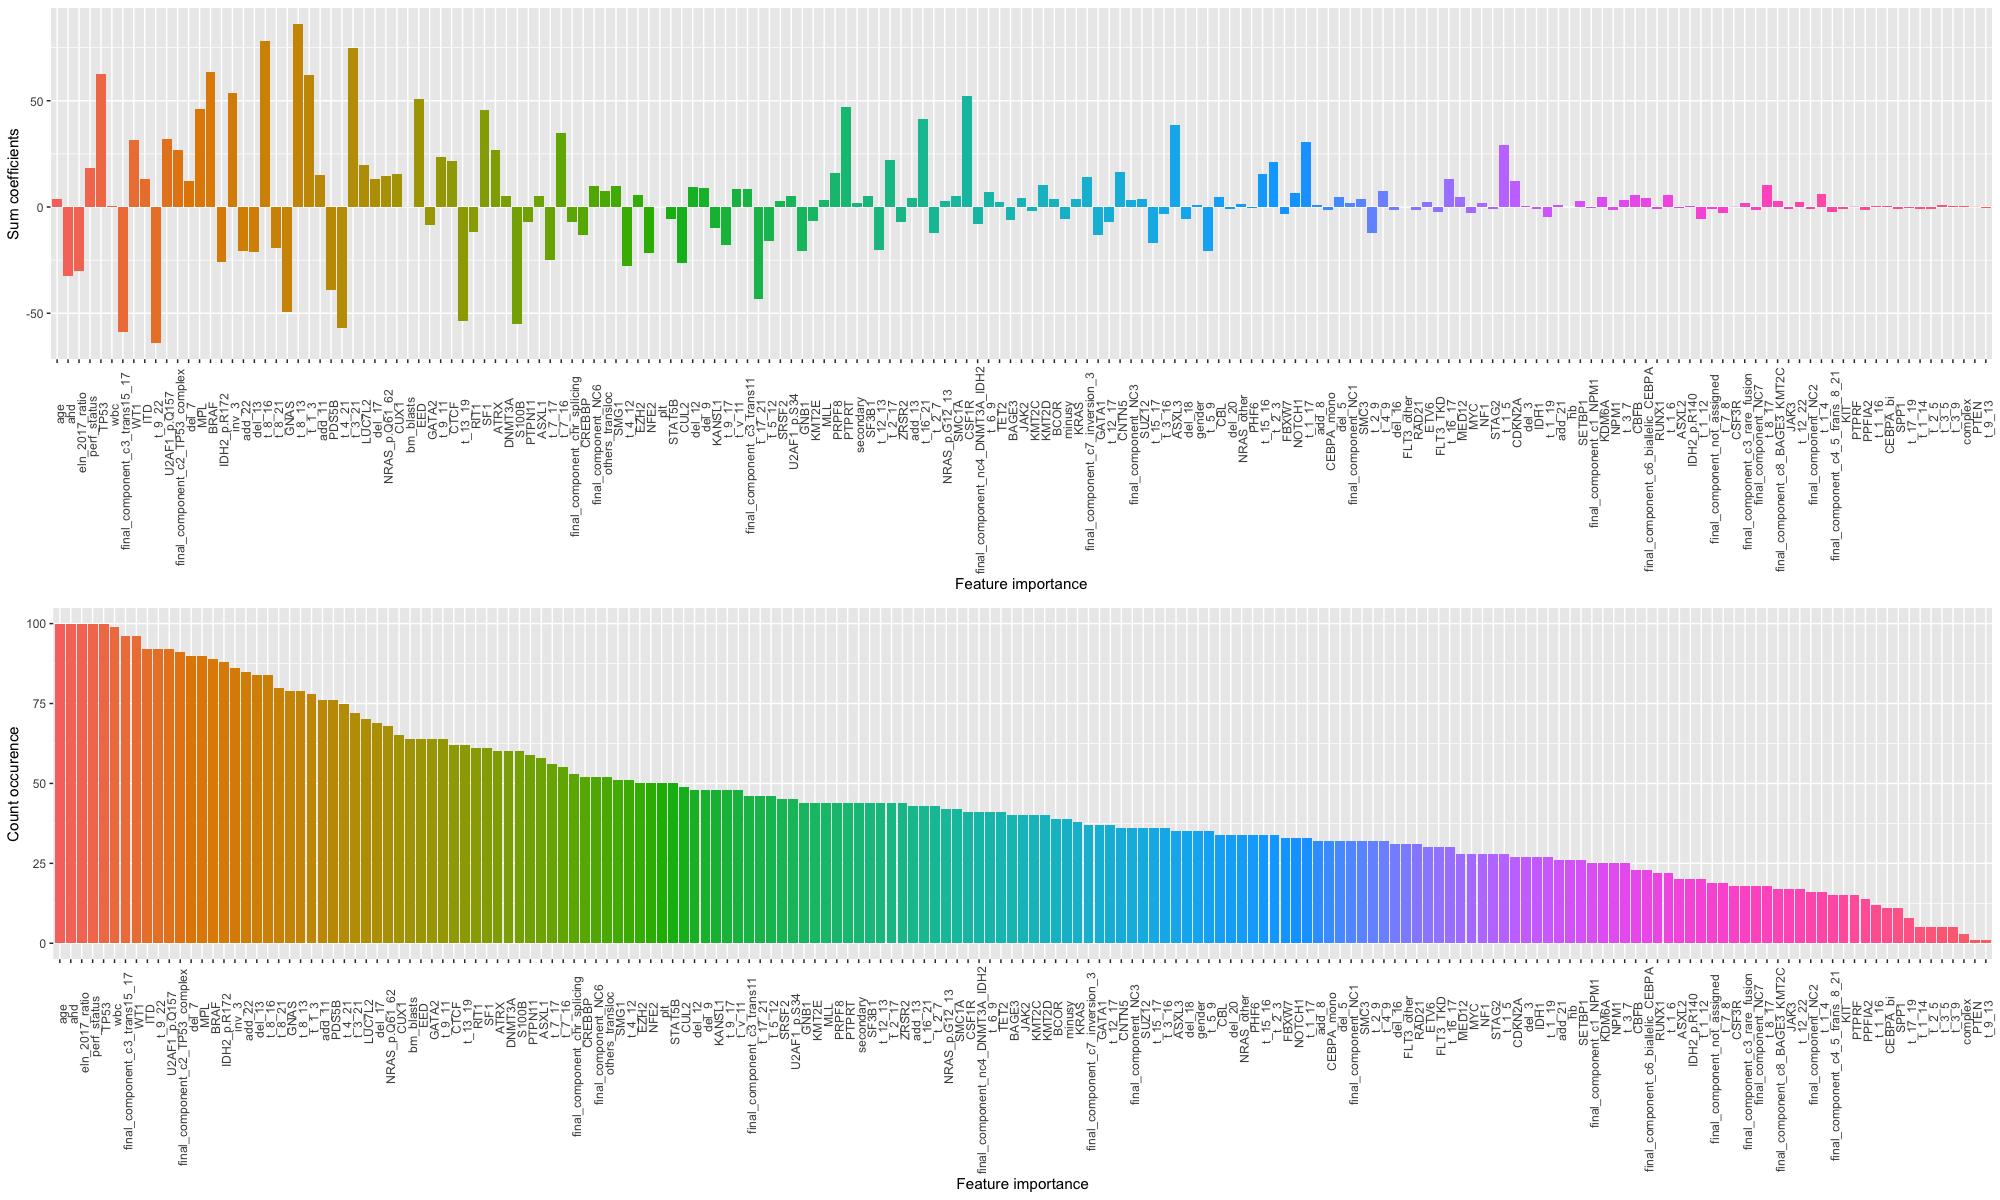

In [167]:
tmp_1 <- bootstrap_all_glm  %>% group_by(feature) %>% summarise_all(sum)
tmp_2 <- bootstrap_all_glm  %>% group_by(feature) %>% count(feature)
set_notebook_plot_size(20,12)
p1 <- ggplot(merge(tmp_1,tmp_2,by='feature'),aes(x=reorder(feature,-n),y=coef)) +
    geom_bar(stat = "identity", aes(fill = reorder(feature,-n)))+
    theme(legend.position="none",axis.text.x = element_text(angle = 90, hjust = 0.8,vjust=0.8))+xlab("Feature importance")+labs(fill = " Feature importance labels")+ylab("Sum coefficients")
p2 <- ggplot(merge(tmp_1,tmp_2,by='feature'),aes(x=reorder(feature,-n),y=n)) +
    geom_bar(stat = "identity", aes(fill = reorder(feature,-n)))+
    theme(legend.position="none",axis.text.x = element_text(angle = 90, hjust = 0.8,vjust=0.8))+xlab("Feature importance")+labs(fill = " Feature importance labels")+ylab("Count occurence")
grid.arrange(p1,p2,nrow=2)

In [ ]:
# VARIABLES LIKE AGE IMPACT THE MODELS NOT WITH THEIR CONTRIBUTION TO THE MODEL BUT MORE IMPORTANTLY BY THE SELECTION OF OTHER VARIABLES THAT WERE NOT SELECTED BEFORE.
# we can see this by comparing count occurence of correlated variables to the age like SRSF2!!

In [168]:
for (col in colnames(read.table("all_features_reduced_glm.tsv",sep='\t'))){
    print(mean(read.table("all_features_reduced_glm.tsv",sep='\t')[,col]))
    print(mean(read.table('final_prognosis/all_features.tsv',sep='\t')[,col]))
    }

[1] 0.7266467
[1] 0.7039356
[1] 0.7258322
[1] 0.7135659
[1] 0.7256123
[1] 0.7158077
[1] 0.7253834
[1] 0.7163937
[1] 0.7252226
[1] 0.7168138
[1] 0.7251644
[1] 0.7166285
[1] 0.7251754
[1] 0.7166145
[1] 0.7251135
[1] 0.7165855
[1] 0.7250928
[1] 0.7166317
[1] 0.7250941
[1] 0.7166681
[1] 0.7251008
[1] 0.7164022


In [169]:
# LETS LOOK AT VIMP WHEN BOOTSTRAPPING WITH REDUCED FEATURES (make sure you have the reduced features)

In [179]:
tmp_1_pos <- tmp_1[tmp_1$coef>0,]
tmp_1_neg <-  tmp_1[tmp_1$coef<0,]
features_reduced <- union(union(tmp_1_pos[tmp_1_pos$coef > quantile(tmp_1_pos$coef,0.90),]$feature,tmp_1_neg[tmp_1_neg$coef < quantile(tmp_1_neg$coef,0.15),]$feature),tmp_2[tmp_2$n > quantile(tmp_2$n,0.85),]$feature)
bootstrap_all_glm_reduced <- bootstrapping(features_reduced,x,y,100,0.7,50,"glm")

[1] "Start Bootstrapping"


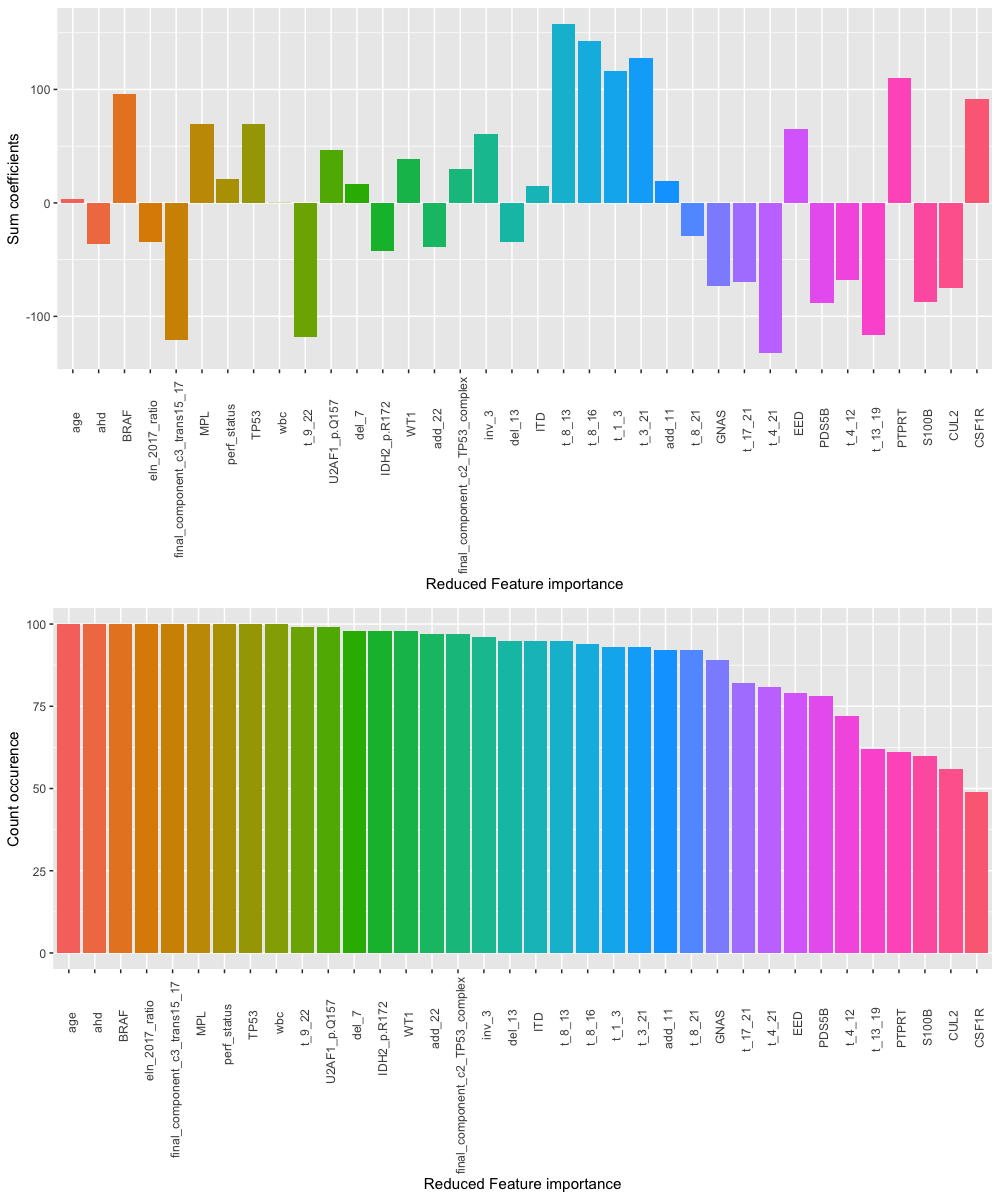

In [181]:
tmp_1 <- bootstrap_all_glm_reduced  %>% group_by(feature) %>% summarise_all(sum)
tmp_2 <- bootstrap_all_glm_reduced  %>% group_by(feature) %>% count(feature)
set_notebook_plot_size(10,12)
p1 <- ggplot(merge(tmp_1,tmp_2,by='feature'),aes(x=reorder(feature,-n),y=coef)) +
    geom_bar(stat = "identity", aes(fill = reorder(feature,-n)))+
    theme(legend.position="none",axis.text.x = element_text(angle = 90, hjust = 0.8,vjust=0.8))+xlab("Reduced Feature importance")+labs(fill = " Reduced Feature importance labels")+ylab("Sum coefficients")
p2 <- ggplot(merge(tmp_1,tmp_2,by='feature'),aes(x=reorder(feature,-n),y=n)) +
    geom_bar(stat = "identity", aes(fill = reorder(feature,-n)))+
    theme(legend.position="none",axis.text.x = element_text(angle = 90, hjust = 0.8,vjust=0.8))+xlab("Reduced Feature importance")+labs(fill = " Reduced Feature importance labels")+ylab("Count occurence")
grid.arrange(p1,p2,nrow=2)

# NO AGE

In [7]:
bootstrap_all_glm_no_age <- bootstrapping(all_features_without_age,x,y,100,0.7,50,"glm")


[1] "Start Bootstrapping"


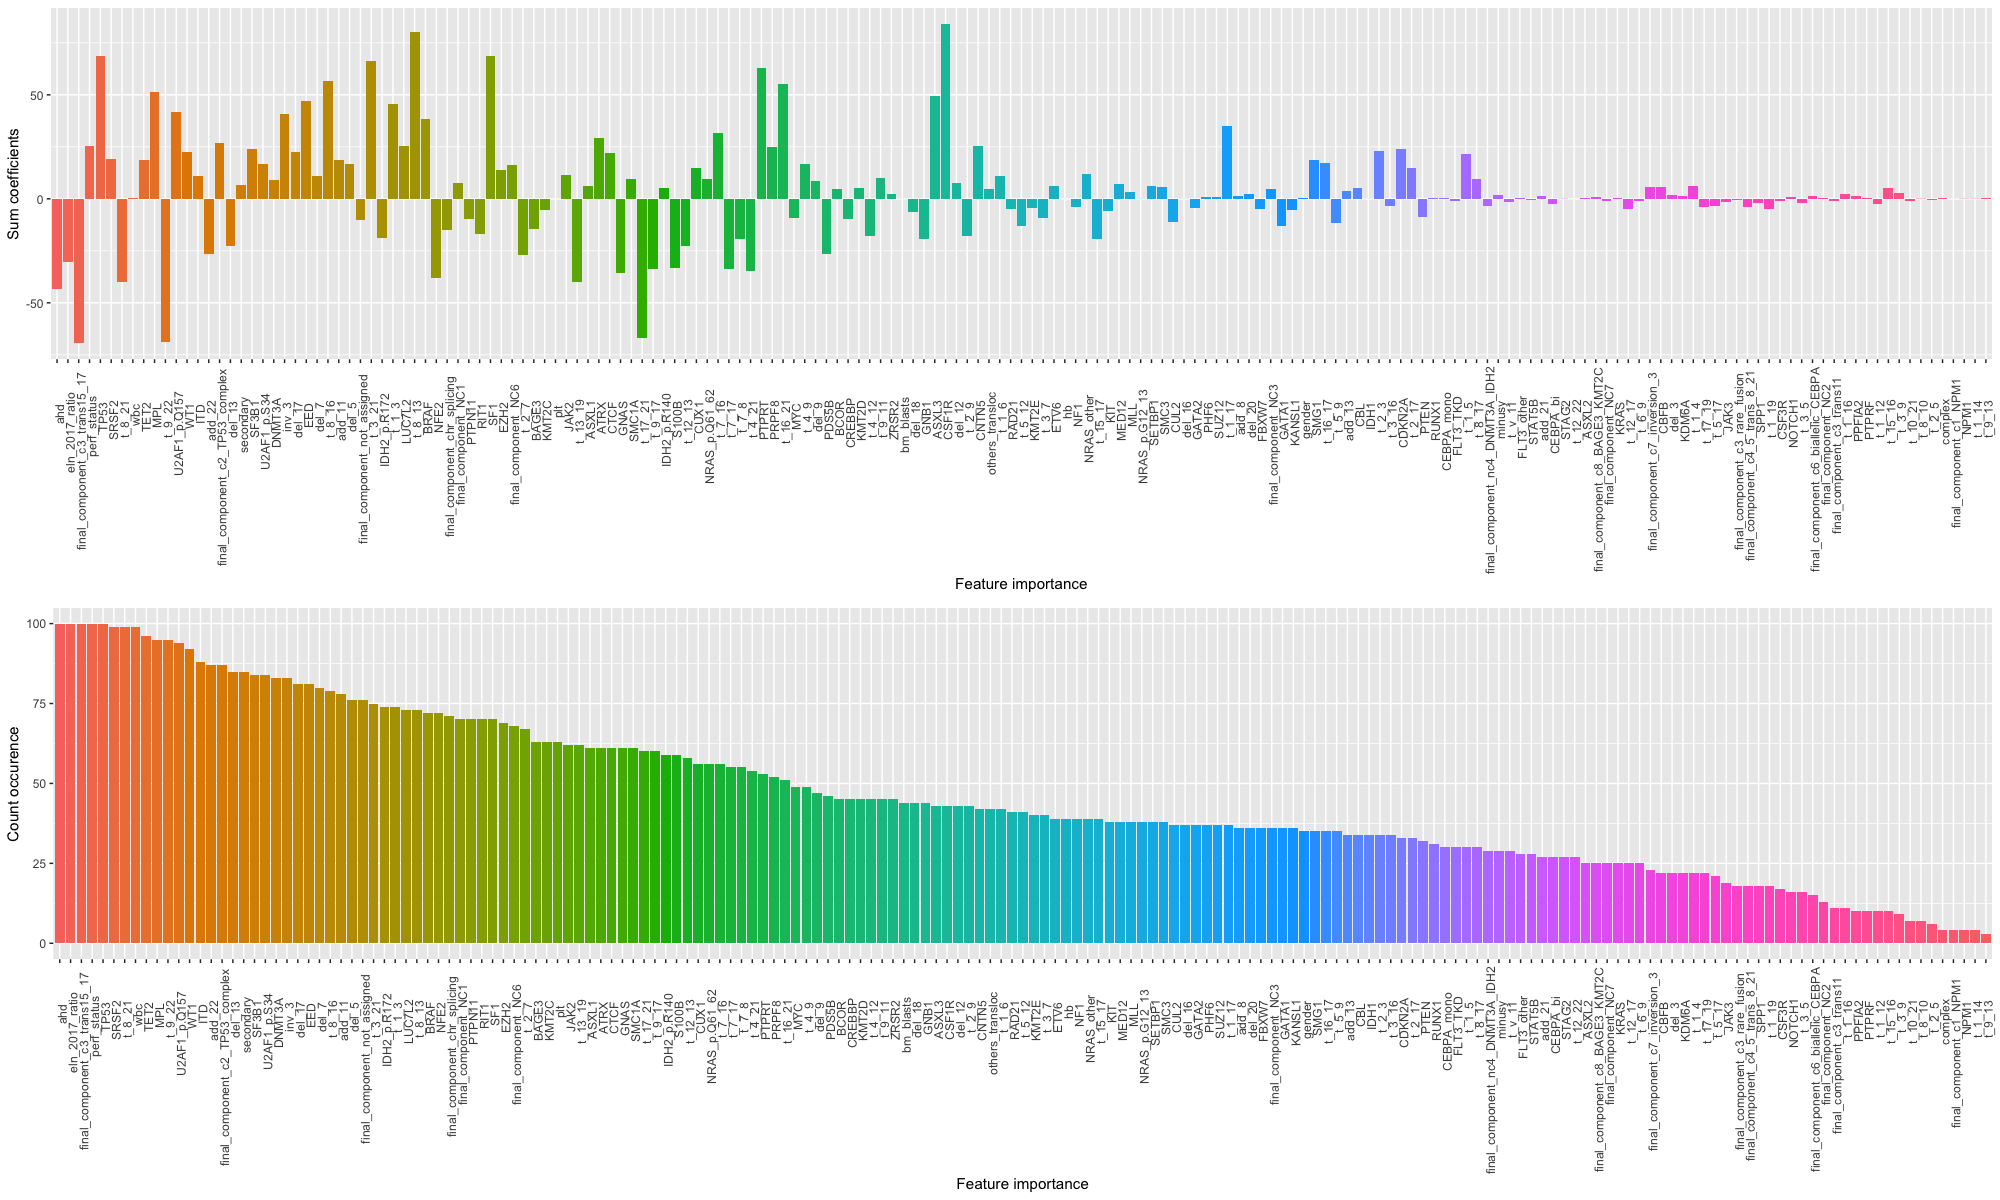

In [183]:
tmp_1 <- bootstrap_all_glm_no_age %>% group_by(feature) %>% summarise_all(sum)
tmp_2 <- bootstrap_all_glm_no_age %>% group_by(feature) %>% count(feature)
set_notebook_plot_size(20,12)
p1 <- ggplot(merge(tmp_1,tmp_2,by='feature'),aes(x=reorder(feature,-n),y=coef)) +
    geom_bar(stat = "identity", aes(fill = reorder(feature,-n)))+
    theme(legend.position="none",axis.text.x = element_text(angle = 90, hjust = 0.8,vjust=0.8))+xlab("Feature importance")+labs(fill = " Feature importance labels")+ylab("Sum coefficients")
p2 <- ggplot(merge(tmp_1,tmp_2,by='feature'),aes(x=reorder(feature,-n),y=n)) +
    geom_bar(stat = "identity", aes(fill = reorder(feature,-n)))+
    theme(legend.position="none",axis.text.x = element_text(angle = 90, hjust = 0.8,vjust=0.8))+xlab("Feature importance")+labs(fill = " Feature importance labels")+ylab("Count occurence")
grid.arrange(p1,p2,nrow=2)

In [182]:
for (col in colnames(read.table("all_features_reduced_glm_without_age.tsv",sep='\t'))){
    print(mean(read.table("all_features_reduced_glm_without_age.tsv",sep='\t')[,col]))
    print(mean(read.table('final_prognosis/all_features_without_age.tsv',sep='\t')[,col]))
    }

[1] 0.6885553
[1] 0.6728126
[1] 0.685281
[1] 0.6763334
[1] 0.6839879
[1] 0.6759712
[1] 0.6834084
[1] 0.675591
[1] 0.6830125
[1] 0.6753319
[1] 0.6825245
[1] 0.6752224
[1] 0.6824511
[1] 0.6751734
[1] 0.6823719
[1] 0.6750394
[1] 0.6822911
[1] 0.6752398
[1] 0.6819235
[1] 0.6751963
[1] 0.6819126
[1] 0.6751262


In [185]:
tmp_1_pos <- tmp_1[tmp_1$coef>0,]
tmp_1_neg <-  tmp_1[tmp_1$coef<0,]
features_reduced <- union(union(tmp_1_pos[tmp_1_pos$coef > quantile(tmp_1_pos$coef,0.90),]$feature,tmp_1_neg[tmp_1_neg$coef < quantile(tmp_1_neg$coef,0.15),]$feature),tmp_2[tmp_2$n > quantile(tmp_2$n,0.85),]$feature)
bootstrap_all_glm_no_age_reduced <- bootstrapping(features_reduced,x,y,100,0.7,50,"glm")

[1] "Start Bootstrapping"


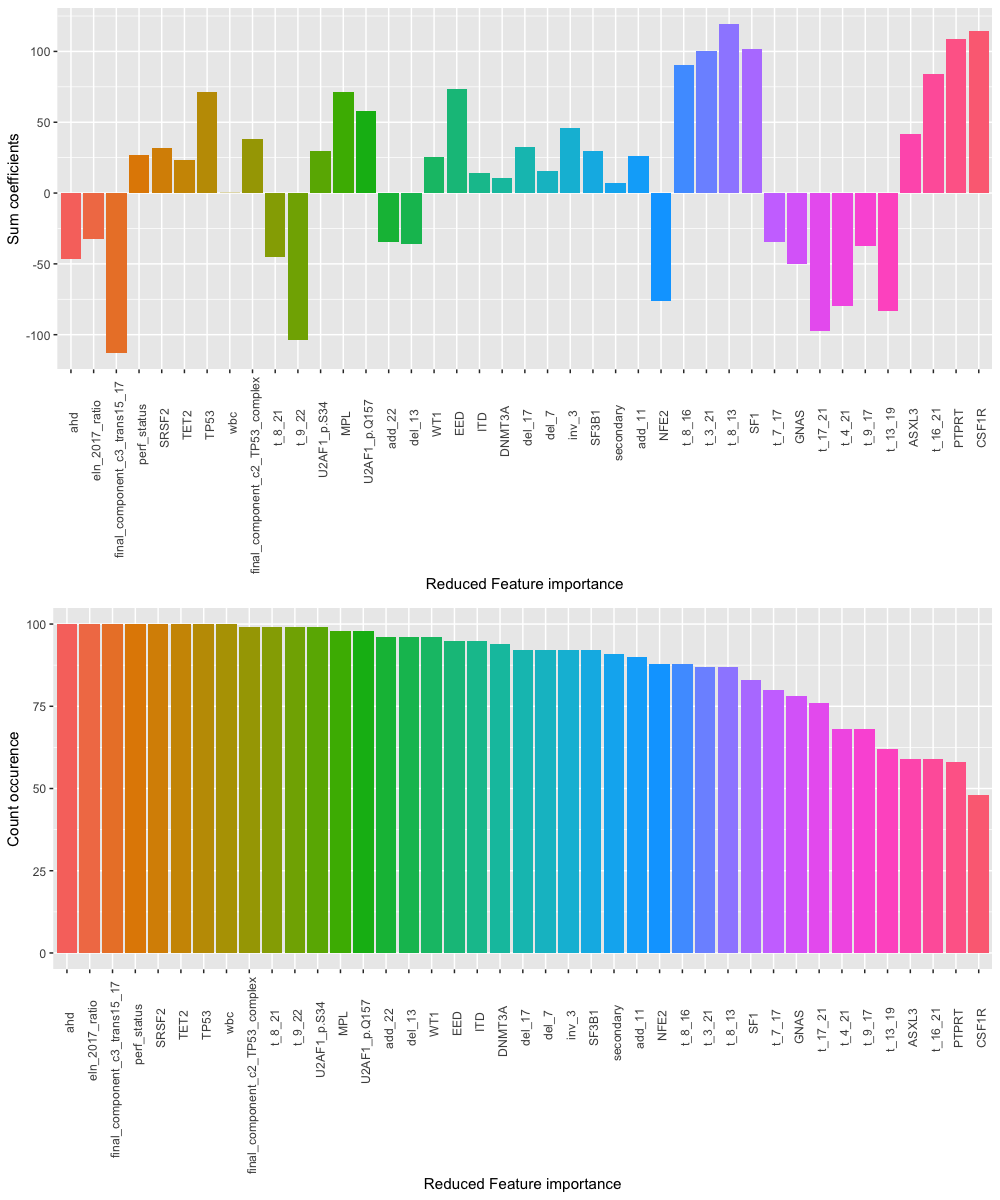

In [186]:
tmp_1 <- bootstrap_all_glm_no_age_reduced  %>% group_by(feature) %>% summarise_all(sum)
tmp_2 <- bootstrap_all_glm_no_age_reduced  %>% group_by(feature) %>% count(feature)
set_notebook_plot_size(10,12)
p1 <- ggplot(merge(tmp_1,tmp_2,by='feature'),aes(x=reorder(feature,-n),y=coef)) +
    geom_bar(stat = "identity", aes(fill = reorder(feature,-n)))+
    theme(legend.position="none",axis.text.x = element_text(angle = 90, hjust = 0.8,vjust=0.8))+xlab("Reduced Feature importance")+labs(fill = " Reduced Feature importance labels")+ylab("Sum coefficients")
p2 <- ggplot(merge(tmp_1,tmp_2,by='feature'),aes(x=reorder(feature,-n),y=n)) +
    geom_bar(stat = "identity", aes(fill = reorder(feature,-n)))+
    theme(legend.position="none",axis.text.x = element_text(angle = 90, hjust = 0.8,vjust=0.8))+xlab("Reduced Feature importance")+labs(fill = " Reduced Feature importance labels")+ylab("Count occurence")
grid.arrange(p1,p2,nrow=2)

# II) RANDOM FOREST

In [26]:
# Chose features you want with design
x <- data.matrix(df_final)
design=x[,all_features]
# Parallel CV
print("start CV")
rescv = mclapply(seq(nexp),
               FUN=function(iexp) {
                   set.seed(17)
                   cat(".")
                   vTrain = design[-folds[[iexp]],,drop=F]
                   vTest = design[folds[[iexp]],,drop=F]
                   lTrain = response[-folds[[iexp]],]
                   lTest = response[folds[[iexp]],]
                   # Train and Predict
                   #cvfit = cv.glmnet(vTrain, lTrain, family="cox", alpha=0.1, nfolds=10, grouped=TRUE)
                   cvfit = rfsrc(Surv(time, status) ~ ., data=data.frame(vTrain,lTrain), ntree=3, importance="TRUE",nodesize=2)
    
         #           # Predict
                   risk.predict = predict(cvfit, data.frame(vTest), importance="TRUE")$predicted
                   ci.test = suppressWarnings(survConcordance(Surv(time,status) ~ risk.predict, as.data.frame(lTest)))
                   # Evaluate CI on the test
                   #return(as.vector(coef(cvfit,s="lambda.min")))
                   #return (as.vector(ci.test$concordance))
                   return(list(as.matrix(cvfit$importance),as.vector(ci.test$concordance)))  ## return a list with dataframe for variable importance and concordance index of the exp
               },
               mc.cores=1
               )


[1] "start CV"


In [ ]:
rf_results <- rescv[[1]][[1]]
colnames(rf_results)[1] <- "exp_1"
for (i in 2:length(rescv)){
    rf_results <-cbind(rf_results,rescv[[i]][[1]])
    colnames(rf_results)[i] <- paste("exp",i,sep="_")
}
#rf_results <-as.data.frame(rf_results)
#rf_results$median <- apply(rf_results,1, median, na.rm = TRUE)
#rf_results$features <-rownames(rf_results)
#rf_results <- rf_results[(apply(rf_results[,1:nfolds*nrepeats],1, mean, na.rm = TRUE)!=0) & (apply(rf_results[,1:nfolds*nrepeats],1, median, na.rm = TRUE)!=0),]
#rf_results <-melt(rf_results,id='features')
#colnames(rf_results) <- c('features','exp','value')
#set_notebook_plot_size(20,15)
#ggplot(rf_results,aes(x=reorder(features,-value),y=value)) +
#    geom_boxplot(aes(fill = reorder(features,-value)), notch=F)+
#    theme(legend.position="top",axis.text.x = element_text(angle = 90, hjust = 0.8,vjust=0.8))+xlab("Feature importance")+labs(fill = " Feature importance labels")

In [ ]:
#RF WITH SUBSET OF FEATURES SELECTED WITH FEATURE IMPORTANCE

In [ ]:
# Chose features you want with design
x <- data.matrix(df_final)
design=x[,all_features]
# Parallel CV
print("start CV")
rescv = mclapply(seq(nexp),
               FUN=function(iexp) {
                   set.seed(17)
                   cat(".")
                   vTrain = design[-folds[[iexp]],,drop=F]
                   vTest = design[folds[[iexp]],,drop=F]
                   lTrain = response[-folds[[iexp]],]
                   lTest = response[folds[[iexp]],]
                   # Train and Predict
                   #cvfit = cv.glmnet(vTrain, lTrain, family="cox", alpha=0.1, nfolds=10, grouped=TRUE)
                   cvfit = rfsrc(Surv(time, status) ~ ., data=data.frame(vTrain,lTrain), ntree=1050, importance="TRUE",nodesize=20)
    
                    # Predict
                   risk.predict = predict(cvfit, data.frame(vTest), importance="TRUE")$predicted
                   ci.test = suppressWarnings(survConcordance(Surv(time,status) ~ risk.predict, as.data.frame(lTest)))
                   # Evaluate CI on the test
                   #return(as.vector(coef(cvfit,s="lambda.min")))
                   #return (as.vector(ci.test$concordance))
                   return(list(as.matrix(cvfit$importance),as.vector(ci.test$concordance)))  ## return a list with dataframe for variable importance and concordance index of the exp
               },
               mc.cores=50
               )
rf_results <- rescv[[1]][[1]]
colnames(rf_results)[1] <- "exp_1"
for (i in 2:length(rescv)){
    rf_results <-cbind(rf_results,rescv[[i]][[1]])
    colnames(rf_results)[i] <- paste("exp",i,sep="_")
}
rf_results <-as.data.frame(rf_results)
rf_results$median <- apply(rf_results,1, median, na.rm = TRUE)
rf_results$features <-rownames(rf_results)
rf_results <- rf_results[(apply(rf_results[,1:nfolds*nrepeats],1, mean, na.rm = TRUE)!=0) & (apply(rf_results[,1:nfolds*nrepeats],1, median, na.rm = TRUE)!=0),]
rf_results <-melt(rf_results,id='features')
colnames(rf_results) <- c('features','exp','value')
set_notebook_plot_size(20,15)
ggplot(rf_results,aes(x=reorder(features,-value),y=value)) +
    geom_boxplot(aes(fill = reorder(features,-value)), notch=F)+
    theme(legend.position="top",axis.text.x = element_text(angle = 90, hjust = 0.8,vjust=0.8))+xlab("Feature importance")+labs(fill = " Feature importance labels")

# II) COX BOOST

In [9]:
bootstrap_all_boost <- bootstrapping(all_features,x,y,1,0.7,50,"boost")


[1] "Start Bootstrapping"
.

In [10]:
bootstrap_all_boost

,feature,coef
1,eln_2017_ratio,-0.2433502882
2,ASXL1,0.0044965619
26,ITD,0.0242854450
32,GNB1,-0.0002936030
33,IDH1,-0.0019954944
35,IDH2_p.R172,-0.0013673158
81,TP53,0.0143512234
84,WT1,0.0043652996
90,add_22,-0.0025932050
96,del_12,0.0013695926


In [ ]:
tmp_1 <- bootstrap_all_boost %>% group_by(feature) %>% summarise_all(sum)
tmp_2 <- bootstrap_all_boost %>% group_by(feature) %>% count(feature)
set_notebook_plot_size(20,20)
ggplot(merge(tmp_1,tmp_2,by='feature'),aes(x=reorder(feature,-coef),y=coef)) +
    geom_bar(stat = "identity", aes(fill = reorder(feature,-coef)))+
    theme(legend.position="top",axis.text.x = element_text(angle = 90, hjust = 0.8,vjust=0.8))+xlab("Feature importance")+labs(fill = " Feature importance labels")

In [ ]:
bootstrap_all_boost_no_age <- bootstrapping(all_features_without_age,x,y,100,0.7,50,"glm")


In [ ]:
tmp_1 <- bootstrap_all_boost_no_age %>% group_by(feature) %>% summarise_all(sum)
tmp_2 <- bootstrap_all_boost_no_age %>% group_by(feature) %>% count(feature)
set_notebook_plot_size(20,20)
ggplot(merge(tmp_1,tmp_2,by='feature'),aes(x=reorder(feature,-coef),y=coef)) +
    geom_bar(stat = "identity", aes(fill = reorder(feature,-coef)))+
    theme(legend.position="top",axis.text.x = element_text(angle = 90, hjust = 0.8,vjust=0.8))+xlab("Feature importance")+labs(fill = " Feature importance labels")

# III) RANDOM EFFECTS

In [ ]:
bootstrap_all_rfx <- bootstrapping(all_features,x,y,100,0.7,50,"rfx")


In [ ]:
tmp_1 <- bootstrap_all_rfx %>% group_by(feature) %>% summarise_all(sum)
tmp_2 <- bootstrap_all_rfx %>% group_by(feature) %>% count(feature)
set_notebook_plot_size(20,20)
ggplot(merge(tmp_1,tmp_2,by='feature'),aes(x=reorder(feature,-coef),y=coef)) +
    geom_bar(stat = "identity", aes(fill = reorder(feature,-coef)))+
    theme(legend.position="top",axis.text.x = element_text(angle = 90, hjust = 0.8,vjust=0.8))+xlab("Feature importance")+labs(fill = " Feature importance labels")

In [ ]:
bootstrap_all_rfx_no_age <- bootstrapping(all_features_without_age,x,y,100,0.7,50,"glm")


In [ ]:
tmp_1 <- bootstrap_all_rfx_no_age %>% group_by(feature) %>% summarise_all(sum)
tmp_2 <- bootstrap_all_rfx_no_age %>% group_by(feature) %>% count(feature)
set_notebook_plot_size(20,20)
ggplot(merge(tmp_1,tmp_2,by='feature'),aes(x=reorder(feature,-coef),y=coef)) +
    geom_bar(stat = "identity", aes(fill = reorder(feature,-coef)))+
    theme(legend.position="top",axis.text.x = element_text(angle = 90, hjust = 0.8,vjust=0.8))+xlab("Feature importance")+labs(fill = " Feature importance labels")